In [1]:
%run ../data_tools.ipynb
%run ../create_metrics.ipynb

      T_ID   GDAY_DS  HEADER_NO   P_ID  START_CK  BAT_ORDER_NO   PA   AB  RBI  \
0       HH  20160401          0  60404         0             3    1    1    0   
1       HH  20160401          0  62700         1             9    2    2    0   
2       HH  20160401          0  64086         1             7    6    4    0   
3       HH  20160401          0  66740         1             5    6    6    0   
4       HH  20160401          0  71347         1             2    6    6    1   
...    ...       ...        ...    ...       ...           ...  ...  ...  ...   
18679   WO  20161009          0  74215        91           374  402  341   80   
18680   WO  20161009          0  78168       139           177  646  560   63   
18681   WO  20161009          0  79130        15           251   80   66    7   
18682   WO  20161009          0  79300        13           429  106   91    9   
18683   WO  20161009          0  79365       122           965  454  411   70   

       RUN  ...  BB  IB  HP

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.graph_objs as go
import xgboost
import shap

from mpl_toolkits.mplot3d import Axes3D
from statsmodels import tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import power_transform
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from plotly.offline import plot
from plotly.offline import init_notebook_mode


init_notebook_mode(connected = True)


In [10]:
crawled_player_batter = pd.read_csv("../Crawler/crawled_player_batter.csv")
crawled_player_pitcher = pd.read_csv("../Crawler/crawled_player_pitcher.csv")
crawled_team_batter = pd.read_csv("../Crawler/crawled_team_batter.csv")
crawled_team_pitcher = pd.read_csv("../Crawler/crawled_team_pitcher.csv")
crawled_csum_player_pitcher = pd.read_csv("../Crawler/crawled_csum_player_pitcher.csv")

crawled_player_batter = crawled_player_batter.drop(["TB"], axis = "columns")
crawled_team_batter = crawled_team_batter.drop(["TB", "START_CK"], axis = "columns")
crawled_player_pitcher = crawled_player_pitcher.drop(["WHIP"], axis = "columns")
crawled_team_pitcher = crawled_team_pitcher.drop(["WHIP"], axis = "columns")
crawled_csum_player_pitcher = crawled_csum_player_pitcher.drop(["WHIP", "MONEY", "AGE_VA", "NAME"], axis = "columns")

In [18]:
total_data = []
for i in list(range(2016, 2021)) :
    rawData = load_data(i)
    Scaling_Money(rawData["player"])
    rawData["player_batter"] = pd.merge(rawData["player_batter"], rawData["player"][["P_ID", "T_ID", "AGE_VA", "MONEY", "NAME"]])
    rawData["player_pitcher"] = pd.merge(rawData["player_pitcher"], rawData["player"][["P_ID", "T_ID", "AGE_VA", "MONEY", "NAME"]])
    
    rawData["player_batter"] = rawData["player_batter"][crawled_player_batter.columns]
    rawData["player_pitcher"] = rawData["player_pitcher"][crawled_player_pitcher.columns]
    rawData["team_batter"] = rawData["team_batter"][crawled_team_batter.columns]
    rawData["team_pitcher"] = rawData["team_pitcher"][crawled_team_pitcher.columns]
    rawData["csum_player_pitcher"] = rawData["csum_player_pitcher"][crawled_csum_player_pitcher.columns]
    
    if i == 2020 :
        rawData["player_batter"] = pd.concat([rawData["player_batter"], crawled_player_batter]).reset_index(drop = True)
        rawData["player_pitcher"] = pd.concat([rawData["player_pitcher"], crawled_player_pitcher]).reset_index(drop = True)
        rawData["team_batter"] = pd.concat([rawData["team_batter"], crawled_team_batter]).reset_index(drop = True)
        rawData["team_pitcher"] = pd.concat([rawData["team_pitcher"], crawled_team_pitcher]).reset_index(drop = True)
        rawData["csum_player_pitcher"] = pd.concat([rawData["csum_player_pitcher"], crawled_csum_player_pitcher]).reset_index(drop = True)
        
    make_batter_metrics(rawData, "player_batter")
    make_batter_metrics(rawData, "team_batter")
    make_pitcher_metrics(rawData, "player_pitcher")
    make_pitcher_metrics(rawData, "team_pitcher")
    total_data.append(rawData)

tableList = []
for key in total_data[0].keys() :
    tableList.append(key)

final_data = dict()
for key in tableList :
    final_data[key] = pd.DataFrame()

for year in range(len(total_data)) :
    for key in tableList :
        if final_data[key].empty :
            final_data[key] = total_data[year][key]
        else :
            final_data[key] = pd.concat([final_data[key], total_data[year][key]], axis = 0)
            
for key in final_data.keys() :
    final_data[key].reset_index(drop = True)

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:134: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning:

In [19]:
metrics_batter = ["K/PA", "OPS", "ISO", "BABIP_BAT", "XR", "XR27", "EQA",
                  "wOBA", "wRAA", "wRC", "wRC+", "BA", "MONEY", "AGE_VA"]

original_stats_batter = ["PA", "AB", "RBI", "RUN", "HIT", "H2", "H3", "HR", "SB", "CS", "SH", "SF",
                         "BB", "IB", "HP", "KK", "GD", "ERR", "LOB"]

final_data["player_batter"] = final_data["player_batter"].sort_values(by = ["T_ID", "GDAY_DS", "HEADER_NO"]).reset_index(drop = True)

final_data["player_batter"] = final_data["player_batter"].loc[final_data["player_batter"]["PA"] != 0].reset_index(drop = True)

result = final_data["player_batter"].groupby(["GDAY_DS", "T_ID", "HEADER_NO"])["PA"].sum()
result = result.to_frame().dropna().reset_index()
result.rename(columns = {"PA" : "PA_SUM"}, inplace = True)

final_data["player_batter"] = pd.merge(final_data["player_batter"], result)
final_data["player_batter"][metrics_batter] = final_data["player_batter"][metrics_batter].mul((final_data["player_batter"]["PA"] / 
                                                                                               final_data["player_batter"]["PA_SUM"]), axis = 0)
final_data["player_batter"] = final_data["player_batter"].drop("PA_SUM", axis = "columns")
BA(final_data, "team_batter")
batter = final_data["player_batter"].groupby(["GDAY_DS", "T_ID", "HEADER_NO"]).sum()
batter = batter.drop(["START_CK", "BAT_ORDER_NO", "BPF"], axis = "columns")
batter = batter.dropna(axis = 0).reset_index(inplace = False)
batter = pd.merge(batter, final_data["team_batter"][["GDAY_DS", "T_ID", "HEADER_NO", "BPF"]])
batter = batter.sort_values(by = ["T_ID", "GDAY_DS"]).reset_index(inplace = False, drop = True)
batter = batter.add_suffix("_BAT")
batter.rename(columns = {"GDAY_DS_BAT" : "GDAY_DS",
                         "T_ID_BAT" : "T_ID",
                         "HEADER_NO_BAT" : "HEADER_NO"}, inplace = True)

,GDAY_DS,T_ID,HEADER_NO,AB,RUN,HIT,H2,H3,HR,RBI,...,BABIP_BAT,XR,XR27,EQA,wOBA,wRAA,wRC,wRC+,BA,BPF
0,20160401,HH,0,46.0,4.0,13.0,2.0,0.0,0.0,4.0,...,0.311538,0.444654,inf,0.682692,0.314359,-0.217619,0.464713,-300.548773,0.288462,NaN
1,20160402,HH,0,43.0,7.0,13.0,4.0,0.0,0.0,7.0,...,0.373333,0.526160,inf,0.767143,0.358130,-0.008962,0.591991,126.195494,0.310000,0.869815
2,20160405,HH,0,35.0,9.0,13.0,4.0,0.0,0.0,8.0,...,0.384146,0.649220,inf,0.955793,0.423171,0.195925,0.687391,100.195907,0.367886,0.779284
3,20160406,HH,0,35.0,4.0,11.0,3.0,0.0,2.0,4.0,...,0.314815,0.507000,inf,0.900000,0.395083,0.087369,0.527921,172.026158,0.333333,0.819850
4,20160407,HH,0,39.0,3.0,12.0,2.0,0.0,2.0,3.0,...,0.297917,0.629550,8.243550,0.837500,0.366700,0.114070,0.603434,-71.445396,0.300000,0.854192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6895,20200918,WO,0,31.0,0.0,4.0,2.0,0.0,0.0,0.0,...,0.186275,0.146824,5.290941,0.449095,0.195206,-0.436198,0.033057,0.000000,0.137255,0.839883
6896,20200919,WO,0,39.0,8.0,15.0,3.0,0.0,0.0,8.0,...,0.562016,0.810558,14.311047,0.893688,0.402349,0.231666,0.862044,0.000000,0.399225,0.839193
6897,20200920,WO,0,37.0,6.0,13.0,2.0,0.0,1.0,6.0,...,0.365854,0.545707,inf,0.902439,0.410463,0.284689,0.722257,0.000000,0.333333,0.835902
6898,20200922,WO,0,32.0,2.0,5.0,1.0,0.0,0.0,2.0,...,0.161905,0.175486,5.119714,0.442857,0.206543,-0.388737,0.093322,0.000000,0.161905,0.820486


In [20]:
final_data["player_pitcher"] = final_data["player_pitcher"].reset_index(drop = True)

metrics_pitcher = ["BB/9", "LOB%", "FIP", "DER", "ERC", "ERA", "WHIP", "RA/9", "MONEY", "AGE_VA"]
final_data["player_pitcher"].sort_values(by = ["T_ID", "GDAY_DS", "HEADER_NO"])
final_data["player_pitcher"] = final_data["player_pitcher"].reset_index(drop = True)

result = final_data["player_pitcher"].groupby(["GDAY_DS", "T_ID", "HEADER_NO"])["INN2"].sum()
result = result.to_frame().dropna().reset_index()
result.rename(columns = {"INN2" : "INN2_SUM"}, inplace = True)

final_data["team_pitcher"] = pd.get_dummies(final_data["team_pitcher"], columns = ["WLS"], drop_first = True)

final_data["player_pitcher"] = pd.merge(final_data["player_pitcher"], result)
final_data["player_pitcher"][metrics_pitcher] = final_data["player_pitcher"][metrics_pitcher].mul((final_data["player_pitcher"]["INN2"] / final_data["player_pitcher"]["INN2_SUM"]), axis = 0)
final_data["player_pitcher"] = final_data["player_pitcher"].drop("INN2_SUM", axis = "columns")
final_data["player_pitcher"] = final_data["player_pitcher"][final_data["player_pitcher"]["INN2"] != 0]
final_data["player_pitcher"] = final_data["player_pitcher"][~np.isinf(final_data["player_pitcher"]["LOB%"])]
pitcher = final_data["player_pitcher"].groupby(["GDAY_DS", "T_ID", "HEADER_NO"]).sum()
pitcher = pitcher.drop(["START_CK", "PPF"], axis = "columns")
pitcher = pitcher.dropna(axis = 0).reset_index(inplace = False)

pitcher = pd.merge(pitcher, final_data["team_pitcher"][["GDAY_DS", "T_ID", "HEADER_NO", "PPF", "WLS_W"]])
pitcher = pitcher.sort_values(by = ["T_ID", "GDAY_DS"]).reset_index(inplace = False, drop = True)
pitcher = pitcher.add_suffix("_PIT")
pitcher.rename(columns = {"GDAY_DS_PIT" : "GDAY_DS",
                          "T_ID_PIT" : "T_ID",
                          "HEADER_NO_PIT" : "HEADER_NO",
                          "WLS_W_PIT" : "WLS"}, inplace = True)

,GDAY_DS,T_ID,HEADER_NO,INN2,R,ER,PA,AB,HIT,H2,...,BB/9,LOB%,FIP,WHIP,RA/9,DER,ERC,ERA,PPF,WLS_W
0,20160401,HH,0,34.0,5.0,4.0,47.0,42.0,9.0,2.0,...,0.352941,0.569693,0.602947,1.147059,0.441176,0.758824,0.505151,0.352941,NaN,0
1,20160402,HH,0,30.0,7.0,7.0,47.0,40.0,12.0,2.0,...,0.600000,0.812319,1.964270,1.800000,0.700000,0.649711,1.286191,0.700000,1.020657,0
2,20160405,HH,0,27.0,5.0,3.0,40.0,32.0,7.0,0.0,...,0.777778,0.638714,2.052631,1.555556,0.555556,0.592593,0.987946,0.333333,0.884735,1
3,20160406,HH,0,27.0,6.0,6.0,40.0,32.0,6.0,2.0,...,0.777778,0.253086,0.391067,1.444444,0.666667,0.792593,0.880415,0.666667,0.915602,0
4,20160407,HH,0,27.0,7.0,7.0,37.0,33.0,7.0,1.0,...,0.333333,0.366572,3.694122,1.222222,0.777778,0.858388,0.774760,0.777778,0.919825,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6894,20200918,WO,0,27.0,2.0,1.0,37.0,36.0,8.0,1.0,...,0.000000,0.629630,-1.522590,0.888889,0.222222,0.726761,0.141074,0.111111,0.815144,0
6895,20200919,WO,0,27.0,7.0,6.0,40.0,37.0,11.0,3.0,...,0.222222,0.661376,2.938565,1.444444,0.777778,0.692982,1.694134,0.666667,0.815722,1
6896,20200920,WO,0,24.0,14.0,9.0,48.0,42.0,18.0,0.0,...,0.625000,0.376781,5.621021,2.875000,1.750000,0.619444,3.852264,1.125000,0.815524,0
6897,20200922,WO,0,27.0,0.0,0.0,33.0,30.0,4.0,0.0,...,0.333333,1.000000,-0.393582,0.777778,0.000000,0.807190,-0.209332,0.000000,0.805929,1


In [67]:
winrate = pd.merge(batter, pitcher)
winrate["PE"] = (winrate["RUN_BAT"] ** 2) / ((winrate["RUN_BAT"] ** 2) + (winrate["R_PIT"] ** 2))

In [150]:
feature = winrate[winrate["T_ID"] == "HH"].drop(["GDAY_DS", "T_ID", "HEADER_NO", "XR27_BAT", "BB_PIT", "KK_PIT", "KK_BAT", "RBI_BAT",
                                                 "H3_BAT", "IB_BAT", "SF_BAT", "H3_PIT", "IB_PIT", "INN2_PIT", "HR_PIT", "SH_BAT", "HP_BAT",
                                                 "H2_BAT", "SB_BAT", "HR_BAT", "CS_BAT", "GD_BAT", "H2_PIT", "HP_PIT", "BB_BAT", "HIT_PIT", "AB_PIT",
                                                 "RUN_BAT", "HIT_BAT", "PA_BAT", "PA_PIT"], axis = "columns").dropna().reset_index(drop = True)
target = feature["WLS"][26:].reset_index(drop = True)

feature = feature.drop(["WLS"], axis = "columns").dropna().reset_index(drop = True)

pca = PCA(n_components = 1)
res = pca.fit_transform(feature[["OPS_BAT", "XR_BAT", "EQA_BAT", "wOBA_BAT", "wRAA_BAT", "wRC_BAT", "BA_BAT"]])

feature = feature.drop(["OPS_BAT", "XR_BAT", "EQA_BAT", "wOBA_BAT", "wRAA_BAT", "wRC_BAT", "BA_BAT"], axis = "columns")
feature["BS_PCA"] = res

pca = PCA(n_components = 1)
res = pca.fit_transform(feature[["ERA_PIT", "R_PIT", "ER_PIT", "RA/9_PIT", "WHIP_PIT", "ERC_PIT"]])
feature["ER_PCA"] = res
feature = feature.drop(["ERA_PIT", "R_PIT", "ER_PIT", "RA/9_PIT", "WHIP_PIT", "ERC_PIT"], axis = "columns")

feature = pd.DataFrame(power_transform(feature, method = "yeo-johnson"), columns = feature.columns, index = feature.index.values)
feature = feature.loc[0:len(target)-1]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000214D4CA0EC8>,
      dtype=object)

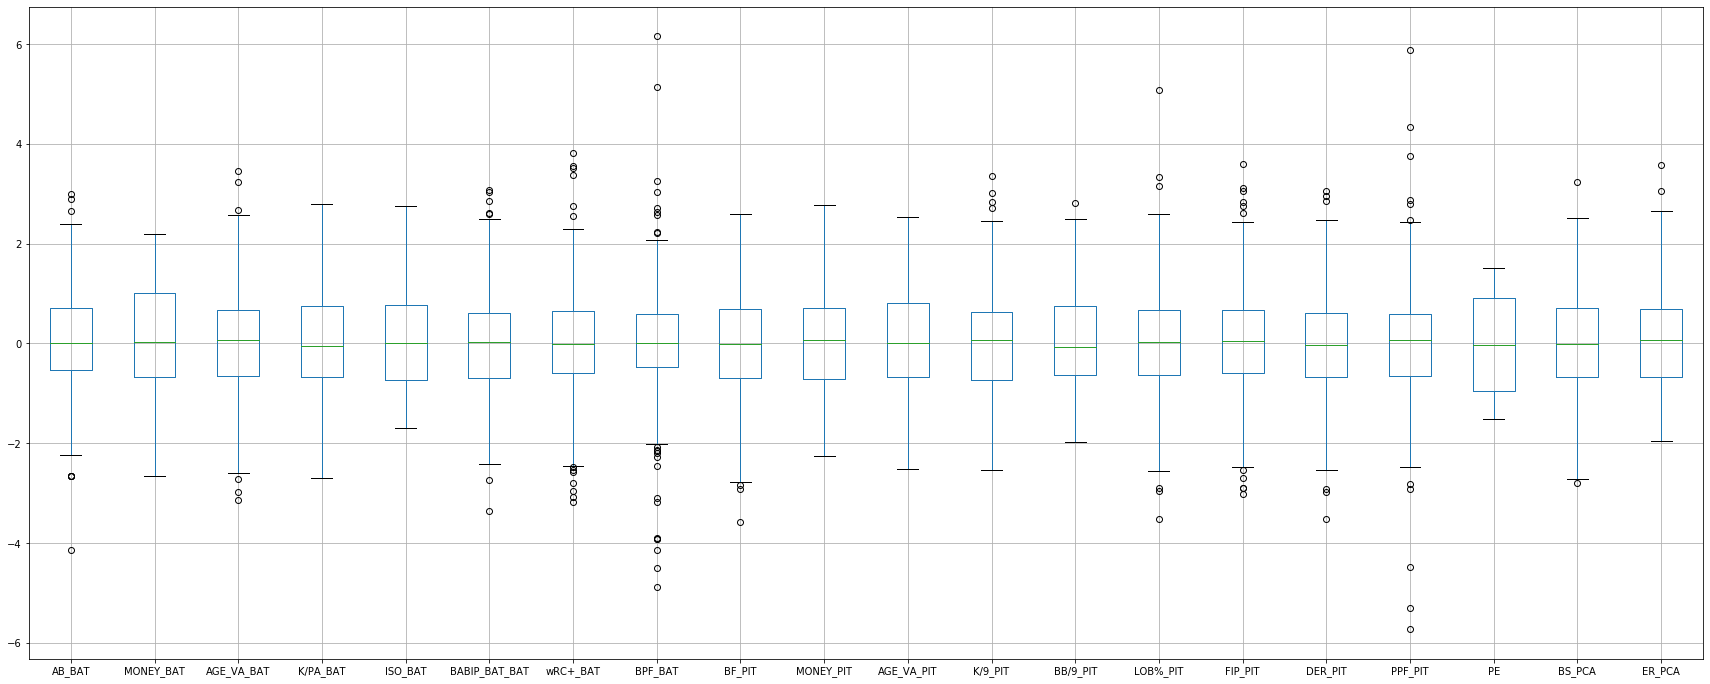

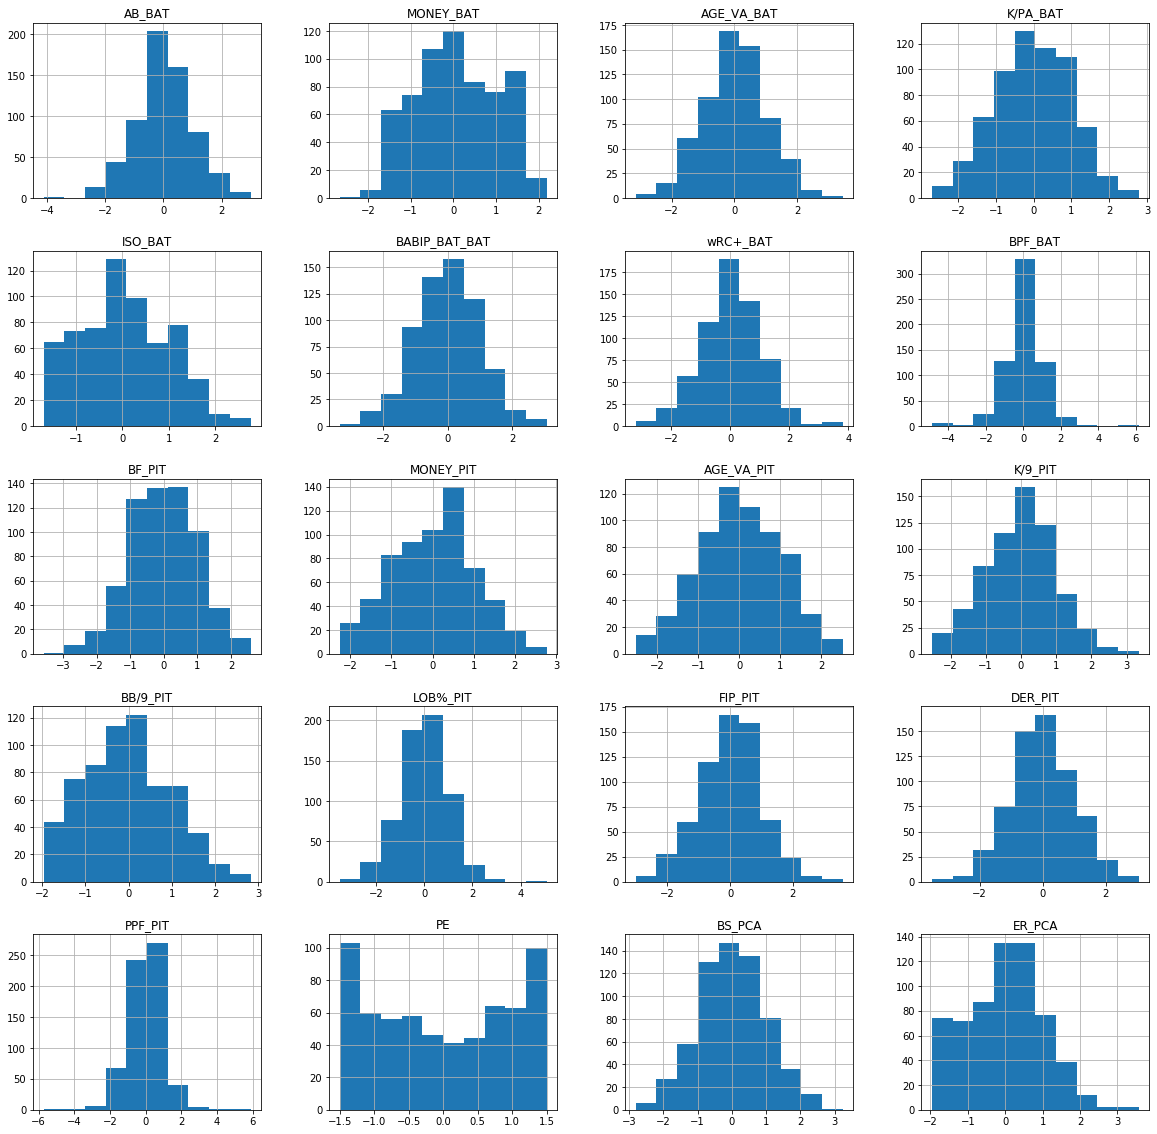

In [151]:
feature.boxplot(figsize = (30, 12))
feature.hist(figsize = (20, 20))

In [152]:
feature.corr(method = "pearson")[feature.columns[:11]]

,AB_BAT,MONEY_BAT,AGE_VA_BAT,K/PA_BAT,ISO_BAT,BABIP_BAT_BAT,wRC+_BAT,BPF_BAT,BF_PIT,MONEY_PIT,AGE_VA_PIT
AB_BAT,1.000000,0.125508,0.062174,-0.191211,0.283751,0.578316,0.331459,0.014114,0.221367,0.037947,0.115181
MONEY_BAT,0.125508,1.000000,0.578930,-0.211822,0.139207,0.103301,0.152304,-0.010101,0.015714,0.209017,0.413238
AGE_VA_BAT,0.062174,0.578930,1.000000,-0.186936,0.023119,0.066708,0.044102,-0.059545,-0.030240,0.197485,0.302698
K/PA_BAT,-0.191211,-0.211822,-0.186936,1.000000,-0.180250,-0.120865,-0.305246,0.050957,0.026123,-0.067571,-0.153387
ISO_BAT,0.283751,0.139207,0.023119,-0.180250,1.000000,0.208094,0.441333,0.013035,0.055337,0.089181,0.099914
BABIP_BAT_BAT,0.578316,0.103301,0.066708,-0.120865,0.208094,1.000000,0.464518,-0.068628,-0.035444,0.110805,0.112690
wRC+_BAT,0.331459,0.152304,0.044102,-0.305246,0.441333,0.464518,1.000000,-0.030368,-0.014157,0.104572,0.159971
BPF_BAT,0.014114,-0.010101,-0.059545,0.050957,0.013035,-0.068628,-0.030368,1.000000,0.057147,-0.022273,0.014697
BF_PIT,0.221367,0.015714,-0.030240,0.026123,0.055337,-0.035444,-0.014157,0.057147,1.000000,-0.099381,-0.016379
MONEY_PIT,0.037947,0.209017,0.197485,-0.067571,0.089181,0.110805,0.104572,-0.022273,-0.099381,1.000000,0.596599


In [88]:
data = go.Scatter3d(x = feature["P_HIT_CN"], y = feature["P_HRA_RT"], z = feature["P_AB_CN"], mode = "markers", marker = dict(size = 2))
layout = go.Layout(autosize = True)
fig = go.Figure(data = [data], layout = layout)
plot(fig)

KeyError: 'P_HIT_CN'

In [154]:
# Find Feature - GBRT
trainFeature = feature.loc[0:feature.shape[0]-26]
trainTarget = target.loc[0:feature.shape[0]-26]

testFeature = feature.loc[feature.shape[0]-26:].reset_index(drop = True)
testTarget = target[feature.shape[0]-26:].reset_index(drop = True)

tree = GradientBoostingClassifier(max_depth = 10,learning_rate = 0.1, n_estimators = 500, subsample = 0.8)
tree.fit(trainFeature, trainTarget)

tree.score(testFeature, testTarget)



0.6538461538461539

In [107]:
#param_grid = {"max_depth" : [2, 3, 4, 5],
#              "learning_rate" : [0.1, 0.2, 0.3, 0.4, 0.5, 1.0],
#              "n_estimators"  : [100, 150, 200, 250, 300, 350, 400, 450, 500],
#              "subsample" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
#              "warm_start" : [True, False]}

#grid = GridSearchCV(tree, param_grid, cv = 3)
#grid.fit(trainFeature, trainTarget)
#grid.score(validFeature, validTarget)

#grid.best_score_
#grid.best_params_

In [155]:
# Find Feature - GBRT

result = tree.predict(testFeature)
result = result.reshape(testTarget.shape[0])

sum(result == testTarget) / len(result)


0.6538461538461539

In [156]:
testTarget.mean()

0.4230769230769231

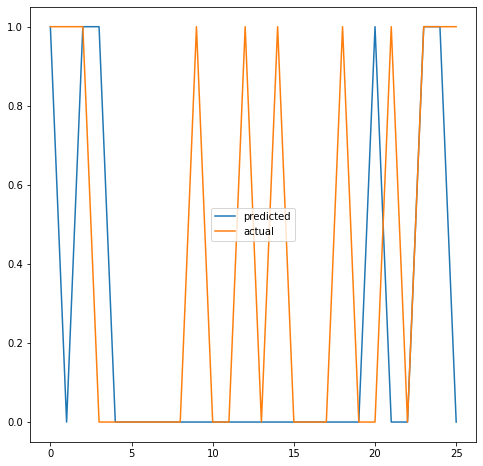

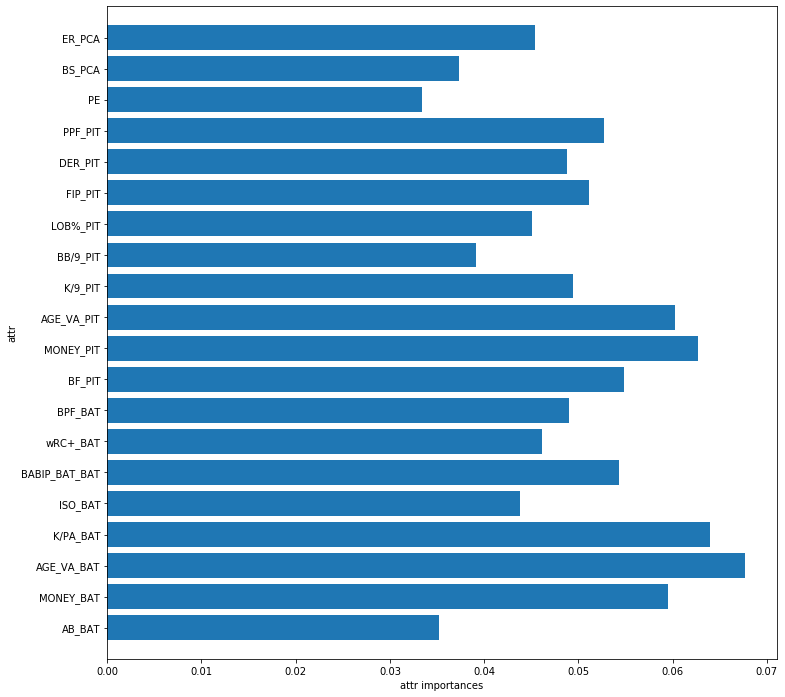

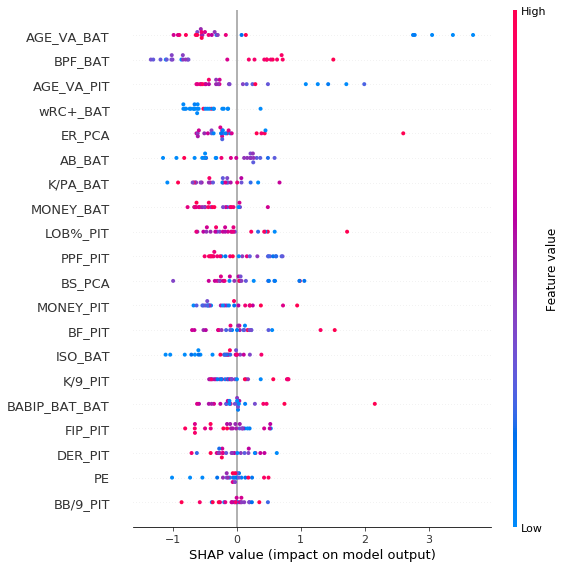

In [157]:
# Find Feature - GBRT

plt.figure(figsize = (8, 8))
plt.plot(result, label = "predicted")
plt.plot(testTarget, label = "actual")
plt.legend()

n_features = trainFeature.shape[1]

plt.figure(figsize = (12, 12))
plt.barh(range(n_features), tree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), testFeature.columns)
plt.xlabel("attr importances")
plt.ylabel("attr")
plt.ylim(-1, n_features)
plt.show()

explainer = shap.TreeExplainer(tree, trainFeature)
shap_values = explainer.shap_values(testFeature, check_additivity = False)
shap.summary_plot(shap_values, testFeature)


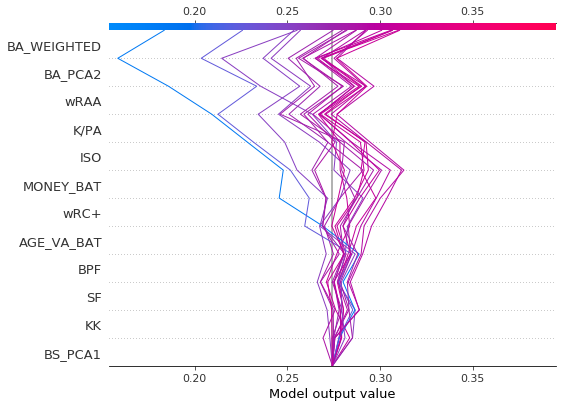

In [756]:
ind = list(range(0, 20))
shap.decision_plot(explainer.expected_value, shap_values[ind, :], testFeature.loc[ind])

In [764]:
shap.initjs()
ind = 0
shap.force_plot(explainer.expected_value, shap_values[ind, :], testFeature.loc[ind])

In [806]:
data = go.Scatter3d(x = HH["OPS"], y = HH["XR"], z = HH["RUN"], mode = "markers", marker = dict(size = 2))
layout = go.Layout(autosize = True)
fig = go.Figure(data = [data], layout = layout)
plot(fig)

'temp-plot.html'

In [834]:
data = go.Scatter3d(x = HH_TSNE[0], y = HH["BS_PCA"], z = target, mode = "markers", marker = dict(size = 2))
layout = go.Layout(autosize = True)
fig = go.Figure(data = [data], layout = layout)
plot(fig)

'temp-plot.html'

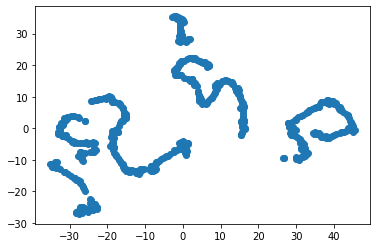

In [917]:
# t-SNE

tsne = TSNE(learning_rate = 300)
transform = pd.DataFrame(tsne.fit_transform(HH.drop(["BS_PCA"], axis = "columns")))
transform[2] = HH["BS_PCA"]

res = scaler.fit(transform)
res = scaler.transform(transform)
HH_TSNE = pd.DataFrame(res)
HH_TSNE

plt.scatter(transform[0], transform[1])
plt.show()

In [110]:
feature["BA"].shift(-1)

0      0.314286
1      0.307692
2      0.161290
3      0.241379
4      0.206897
         ...   
615    0.187500
616    0.103448
617    0.250000
618    0.235294
619         NaN
Name: BA, Length: 620, dtype: float64

In [14]:
feature = batter[batter["T_ID"] == "HH"].drop(["GDAY_DS", "T_ID", "HEADER_NO", "P_ID", "XR27",
                                              "SF", "H3", "IB", "RBI", "GD", "ERR", "HP", "HR", "CS",
                                              "SB", "SH", "H2", "KK", "BB"], axis = "columns").dropna().reset_index(drop = True)


pca = PCA(n_components = 1)
res = pca.fit_transform(feature[["OPS", "XR", "EQA", "wOBA", "wRAA", "wRC", "wRC+", "BA_WEIGHTED"]])

feature = feature.drop(["OPS", "XR", "EQA", "wOBA", "wRAA", "wRC", "wRC+", "BA_WEIGHTED"], axis = "columns")
feature["BS_PCA"] = res

pca = PCA(n_components = 1)
res = pca.fit_transform(feature[["PA", "AB", "HIT"]])
feature = feature.drop(["PA", "AB", "HIT"], axis = "columns")
feature["PA_PCA"] = res

pca = PCA(n_components = 2)
res = pca.fit_transform(feature[["P_HIT_CN", "P_HRA_RT", "P_AB_CN"]])
feature = feature.drop(["P_HIT_CN", "P_HRA_RT", "P_AB_CN"], axis = "columns")
feature[["RT_PCA1", "RT_PCA2"]] = res
#feature = pd.DataFrame(power_transform(feature, method = "yeo-johnson"), columns = feature.columns, index = feature.index.values)
#feature = feature.loc[0:len(target)-1]



In [16]:
target = pd.DataFrame(feature["BA"])
for i in range(-1, -20, -1) :
    temp = feature["BA"].shift(i)
    target["BA_" + str(i)] = temp
target = target.dropna()
target

,BA,BA_-1,BA_-2,BA_-3,BA_-4,BA_-5,BA_-6,BA_-7,BA_-8,BA_-9,BA_-10,BA_-11,BA_-12,BA_-13,BA_-14,BA_-15,BA_-16,BA_-17,BA_-18,BA_-19
0,0.371429,0.314286,0.307692,0.161290,0.241379,0.206897,0.264706,0.375000,0.161290,0.272727,0.205882,0.210526,0.277778,0.393939,0.212121,0.181818,0.129032,0.222222,0.236842,0.394737
1,0.314286,0.307692,0.161290,0.241379,0.206897,0.264706,0.375000,0.161290,0.272727,0.205882,0.210526,0.277778,0.393939,0.212121,0.181818,0.129032,0.222222,0.236842,0.394737,0.225806
2,0.307692,0.161290,0.241379,0.206897,0.264706,0.375000,0.161290,0.272727,0.205882,0.210526,0.277778,0.393939,0.212121,0.181818,0.129032,0.222222,0.236842,0.394737,0.225806,0.285714
3,0.161290,0.241379,0.206897,0.264706,0.375000,0.161290,0.272727,0.205882,0.210526,0.277778,0.393939,0.212121,0.181818,0.129032,0.222222,0.236842,0.394737,0.225806,0.285714,0.178571
4,0.241379,0.206897,0.264706,0.375000,0.161290,0.272727,0.205882,0.210526,0.277778,0.393939,0.212121,0.181818,0.129032,0.222222,0.236842,0.394737,0.225806,0.285714,0.178571,0.218750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,0.205882,0.324324,0.225806,0.333333,0.388889,0.212121,0.242424,0.375000,0.281250,0.156250,0.277778,0.285714,0.232558,0.187500,0.228571,0.172414,0.200000,0.290323,0.258065,0.289474
597,0.324324,0.225806,0.333333,0.388889,0.212121,0.242424,0.375000,0.281250,0.156250,0.277778,0.285714,0.232558,0.187500,0.228571,0.172414,0.200000,0.290323,0.258065,0.289474,0.187500
598,0.225806,0.333333,0.388889,0.212121,0.242424,0.375000,0.281250,0.156250,0.277778,0.285714,0.232558,0.187500,0.228571,0.172414,0.200000,0.290323,0.258065,0.289474,0.187500,0.103448
599,0.333333,0.388889,0.212121,0.242424,0.375000,0.281250,0.156250,0.277778,0.285714,0.232558,0.187500,0.228571,0.172414,0.200000,0.290323,0.258065,0.289474,0.187500,0.103448,0.250000
